In [1]:
import pandas as pd
import numpy as np

from google.colab import drive

# This will prompt you to authenticate and grant access to your Drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
df = pd.read_csv('/content/drive/MyDrive/5253AM/factor data/all_new.csv')
df = df.drop(columns=['Unnamed: 0'])
# reverse value for capitalization(Value) and Accural(Earning Quality)
df['Capitalization'] = -np.log(df['Capitalization'])
df['Accrual'] = -df['Accrual']
df = df.rename(columns={'ROE': 'Profitability', 'Accrual':'Earnings_Quality', 'momentum12':'Momentum',
                        'BtM':'Value'})

In [24]:
df['Date'] = pd.to_datetime(df['Date'])

df = df[df['Date'] >= pd.to_datetime('2020-10')]

df = df.sort_values(by=['Date', 'PERMNO'])

# Calculate monthly returns
df['Monthly_Return'] = df.groupby('PERMNO')['Price'].pct_change()
# Shift within each group and align indices
df['Monthly_Return'] = df.groupby('PERMNO')['Monthly_Return'].transform(lambda x: x.shift(-1))
df = df.dropna(subset=['Monthly_Return'])
df['YearMonth'] = df['Date'].dt.to_period('M')

In [25]:
factor = 'Capitalization'
df1 = df[[factor, 'Monthly_Return']]
df1 = df1.dropna()
# Rank the equities
ranked_data = df1.sort_values(factor, ascending=False)

In [26]:
ranked_data

,Capitalization,Monthly_Return
5270,-10.363172,0.375394
5273,-10.607568,0.185286
5272,-10.663211,-0.054124
5271,-10.695136,-0.110092
5274,-10.777552,0.022989
...,...,...
4829,-21.771396,-0.055269
4828,-21.788793,-0.015712
4848,-21.800724,-0.088678
4846,-21.833549,0.012785


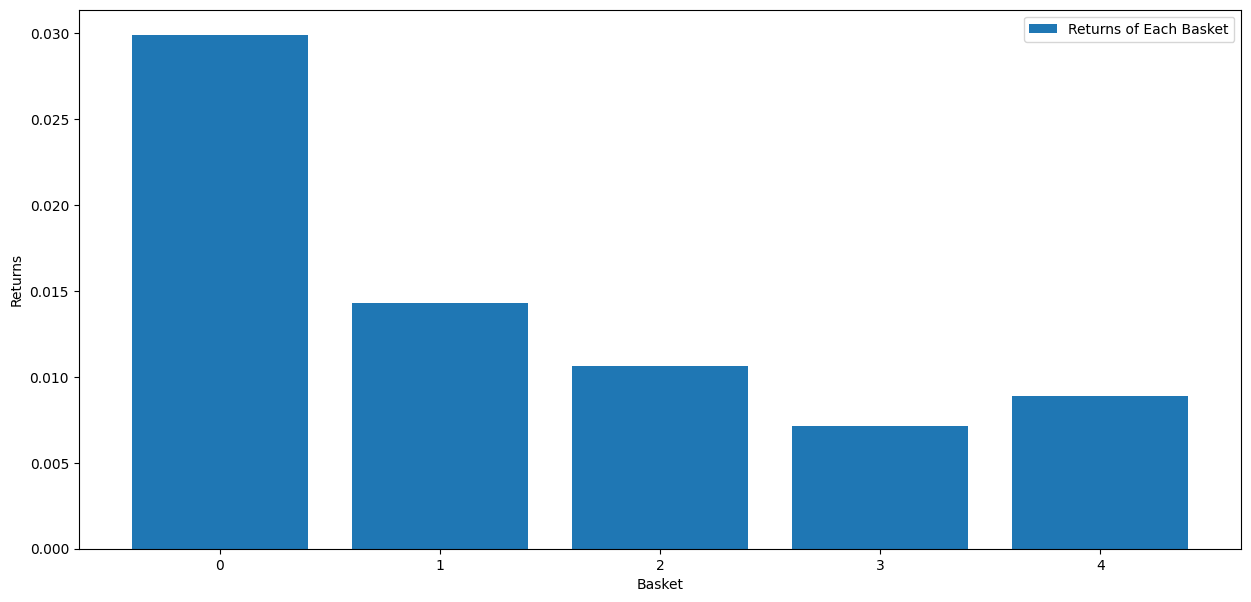

In [27]:
# Compute the returns of each basket with a basket size 500, so total (10000/500) baskets
number_of_baskets = 5
basket_returns = np.zeros(number_of_baskets)

num = int(len(df)/number_of_baskets)
for i in range(number_of_baskets):
    start = i * num
    end = i * num + num
    basket_returns[i] = ranked_data[start:end]['Monthly_Return'].mean()

# Plot the returns of each basket
plt.figure(figsize=(15,7))
plt.bar(range(number_of_baskets), basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket'])
plt.show()

Equal-weighted

Capitalization PNL(net of T-cost): 607738.3188858606


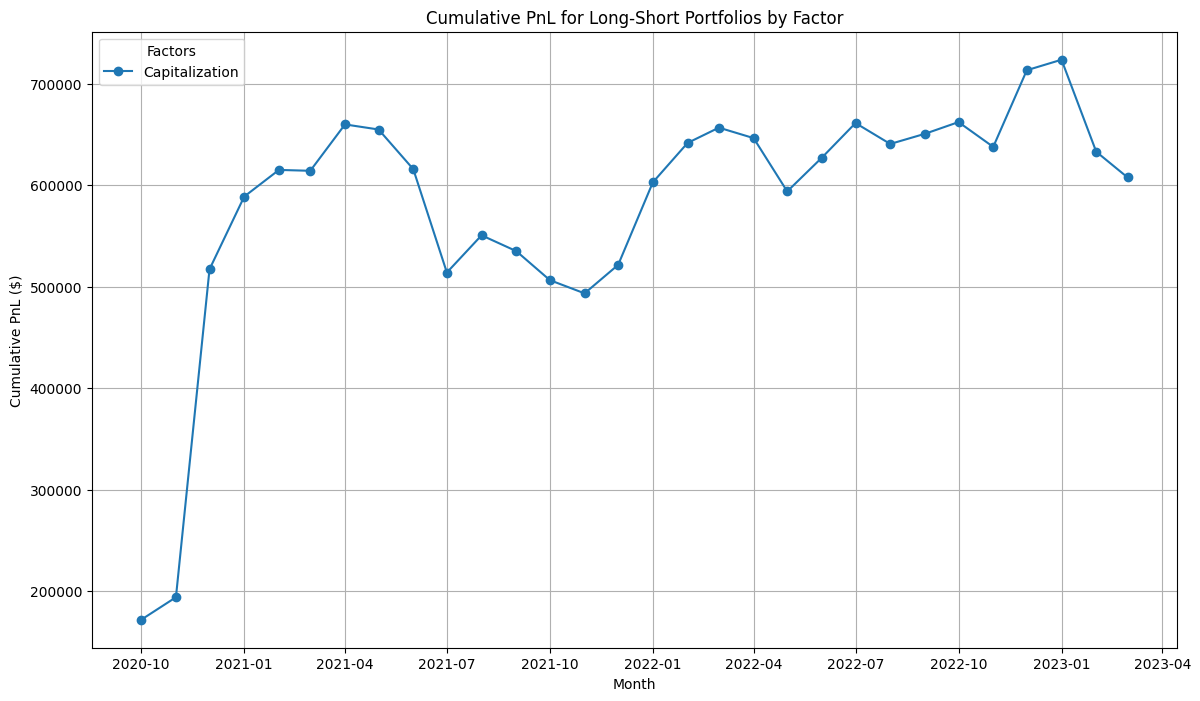

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(42)

# Assume df has columns: PERMNO, Date, Price, Factor1, Factor2, ..., Factor6
# factors = ['Capitalization', 'Profitability', 'Earnings_Quality', 'Momentum', 'Value']
factors = ['Capitalization']
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by=['Date', 'PERMNO'])

# Calculate monthly returns
df['Monthly_Return'] = df.groupby('PERMNO')['Price'].pct_change()
# Shift within each group and align indices
df['Monthly_Return'] = df.groupby('PERMNO')['Monthly_Return'].transform(lambda x: x.shift(-1))
df = df.dropna(subset=['Monthly_Return'])
df['YearMonth'] = df['Date'].dt.to_period('M')


fix_investment_amount = 1000000
transaction_cost = 0.0003  # 0.003% transaction cost
cumulative_pnl = {factor: [] for factor in factors}

# Process each factor individually
for factor in factors:

      factor_pnl = []

      profit = 0.0
      last_month_df = None  # To keep track of the previous month's data

      for month, month_df in df.groupby('YearMonth'):

              month_df = month_df.copy()  # Avoid SettingWithCopyWarning
              month_df = month_df.sort_values(by=['PERMNO'])

              # Rank stocks in each month by the current factor and assign quintiles
              # Larger factor value -> Q1, smaller -> Q5
              month_df['Quintile'] = pd.qcut(month_df[factor].rank(method='dense', ascending=False), 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

              # if it's the first month
              if last_month_df is not None:

                      # Find the overlap between this month's Q1 and last month's Q1
                      current_q1_stocks = month_df.loc[month_df['Quintile'] == 'Q1', 'PERMNO']
                      last_q1_stocks = last_portfolio['PERMNO']

                      # Use intersection to find overlapping stocks
                      overlap_stocks = current_q1_stocks[current_q1_stocks.isin(last_q1_stocks)]

                      # Filter the overlap stocks from the current month's DataFrame
                      overlap = month_df.loc[month_df['PERMNO'].isin(overlap_stocks)]

                      # Find leftover stocks (last month's Q1 stocks that are not in the overlap)
                      leftover_stocks = last_q1_stocks[~last_q1_stocks.isin(overlap_stocks)]

                      # Filter the leftover stocks from the current month's DataFrame
                      leftover = month_df.loc[month_df['PERMNO'].isin(leftover_stocks)]

                      # Rank all stocks in the current month's DataFrame by the factor
                      month_df['Rank'] = month_df[factor].rank(ascending=False, method='dense')

                      # Filter leftover stocks and check their overall rankings
                      leftover_ranks = month_df.loc[month_df['PERMNO'].isin(leftover['PERMNO'])]

                      # Keep stocks from the leftover that are in the top 25% of the entire month's ranking
                      top_25_percentile_cutoff = len(month_df) * 0.25
                      keep = leftover_ranks[leftover_ranks['Rank'] <= top_25_percentile_cutoff]

                      # Calculate how many more stocks are needed for this month's Q1
                      still_need = len(month_df[month_df['Quintile'] == 'Q1']) - len(overlap) - len(keep)

                      if still_need > 0:

                            # Select top `still_need` stocks from this month's ranking
                            top_needed = month_df.loc[~month_df['PERMNO'].isin(overlap['PERMNO']) &
                                                      ~month_df['PERMNO'].isin(keep['PERMNO'])]
                            top_needed = top_needed.nlargest(still_need, factor, keep='first')
                            # Combine to form this month's stock pool
                            long_portfolio = pd.concat([overlap, keep, top_needed])

                      else:
                            long_portfolio = pd.concat([overlap, keep])

                      # Track changes for transcation costs
                      new_permno = long_portfolio['PERMNO']
                      buy_list = list(set(new_permno) - set(last_q1_stocks))
                      sold_list = list(set(last_q1_stocks) - set(new_permno))

                      each_value_prev = fix_investment_amount/len(last_q1_stocks)
                      each_value_new = fix_investment_amount/len(new_permno)

                      sold_list_return = last_month_df[last_month_df['PERMNO'].isin(sold_list)]['Monthly_Return']
                      # e.g. 5k * (1+return1) + 5k * (1+return2) = 5k * (n+sum(return))
                      sell_t_cost = each_value_prev * len(sold_list_return) * sum(sold_list_return) * transaction_cost

                      buy_t_cost = each_value_new * len(buy_list) * transaction_cost



              # If it's the first month, use the current month's Q1 directly
              else:

                  long_portfolio = month_df[month_df['Quintile'] == 'Q1']

                  # Calculate buy transaction cost
                  buy_t_cost = transaction_cost * fix_investment_amount
                  sell_t_cost = 0


              # Calculate long and short portfolio returns
              long_return = long_portfolio['Monthly_Return'].mean()

              short_return = month_df.loc[month_df['Quintile'] == 'Q5', 'Monthly_Return'].mean()


              # Calculate the long-short portfolio return
              long_short_return = long_return - short_return

              # Update pnl
              profit += fix_investment_amount * long_short_return
              profit -= buy_t_cost
              profit -= sell_t_cost

              factor_pnl.append({'Month': month, 'Profit': profit})


              # Save the current month as the last month for the next iteration
              last_portfolio = long_portfolio
              last_month_df = month_df


      # Store cumulative PnL for this factor
      cumulative_pnl[factor] = pd.DataFrame(factor_pnl)

# Convert each factor's results to a DataFrame for plotting
for factor, df_factor in cumulative_pnl.items():
    df_factor['Month'] = df_factor['Month'].dt.to_timestamp()  # Convert Period to Timestamp for plotting

# Plotting
plt.figure(figsize=(14, 8))
for factor, df_factor in cumulative_pnl.items():
    plt.plot(df_factor['Month'], df_factor['Profit'], marker='o', linestyle='-', label=factor)
    print(f'{factor} PNL(net of T-cost):', df_factor['Profit'].iloc[-1])

plt.title('Cumulative PnL for Long-Short Portfolios by Factor')
plt.xlabel('Month')
plt.ylabel('Cumulative PnL ($)')
plt.legend(title='Factors')
plt.grid(True)
plt.show()


Capitalization PNL(net of T-cost): 687629.8312799041


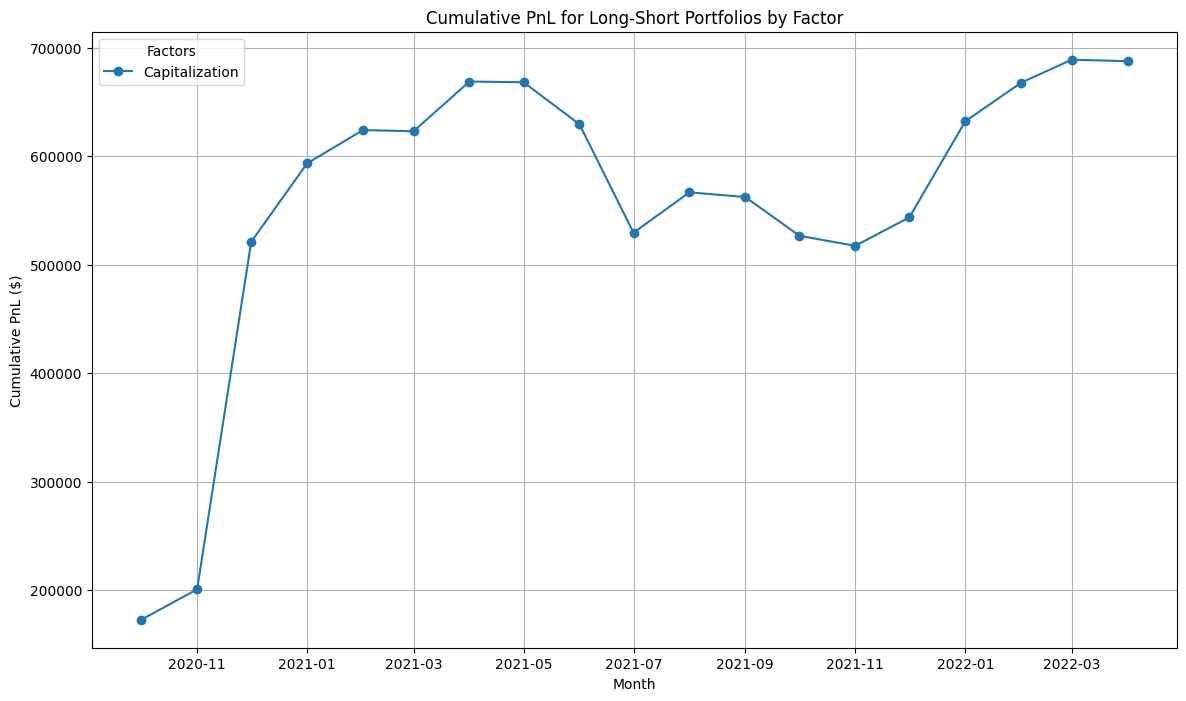

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume df has columns: PERMNO, Date, Price, Factor1, Factor2, ..., Factor6
# factors = ['Capitalization', 'Profitability', 'Earnings_Quality', 'Momentum', 'Value']
factors = ['Capitalization']
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by=['Date', 'PERMNO'])

# Calculate monthly returns
df['Monthly_Return'] = df.groupby('PERMNO')['Price'].pct_change()
# Shift within each group and align indices
df['Monthly_Return'] = df.groupby('PERMNO')['Monthly_Return'].transform(lambda x: x.shift(-1))
df = df.dropna(subset=['Monthly_Return'])
df['YearMonth'] = df['Date'].dt.to_period('M')

def change_position(last_month_df, last_portfolio, month_df, long):

    if long:
      choice = 'Q1'
    else:
      choice = 'Q5'
    # Find the overlap between this month's Q1/5 and last month's Q1/5
    current_q1_stocks = month_df.loc[month_df['Quintile'] == choice, 'PERMNO']
    last_q1_stocks = last_portfolio['PERMNO']

    # Use intersection to find overlapping stocks
    overlap_stocks = current_q1_stocks[current_q1_stocks.isin(last_q1_stocks)]

    # Filter the overlap stocks from the current month's DataFrame
    overlap = month_df.loc[month_df['PERMNO'].isin(overlap_stocks)]

    # Find leftover stocks (last month's Q1 stocks that are not in the overlap)
    leftover_stocks = last_q1_stocks[~last_q1_stocks.isin(overlap_stocks)]

    # Filter the leftover stocks from the current month's DataFrame
    leftover = month_df.loc[month_df['PERMNO'].isin(leftover_stocks)]

    # Rank all stocks in the current month's DataFrame by the factor
    month_df['Rank'] = month_df[factor].rank(ascending=False, method='dense')

    # Filter leftover stocks and check their overall rankings
    leftover_ranks = month_df.loc[month_df['PERMNO'].isin(leftover['PERMNO'])]

    # Keep stocks from the leftover that are in the top 25% of the entire month's ranking
    top_25_percentile_cutoff = len(month_df) * 0.25
    bom_25_percentile_cutoff = len(month_df) * 0.75
    if long:
        keep = leftover_ranks[leftover_ranks['Rank'] <= top_25_percentile_cutoff]
    else:
        keep = leftover_ranks[leftover_ranks['Rank'] >= bom_25_percentile_cutoff]

    # Calculate how many more stocks are needed for this month's Q1/5
    still_need = len(month_df[month_df['Quintile'] == choice]) - len(overlap) - len(keep)

    if still_need > 0:

          # Select top `still_need` stocks from this month's ranking
          top_needed = month_df.loc[~month_df['PERMNO'].isin(overlap['PERMNO']) &
                                    ~month_df['PERMNO'].isin(keep['PERMNO'])]
          if long:
            top_needed = top_needed.nlargest(still_need, factor)
          else:
            top_needed = top_needed.nsmallest(still_need, factor)

          # Combine to form this month's stock pool
          long_portfolio = pd.concat([overlap, keep, top_needed])

    else:
          long_portfolio = pd.concat([overlap, keep])

    # transcation costs part
    new_permno = long_portfolio['PERMNO']
    each_value_prev = fix_investment_amount/len(last_q1_stocks)
    each_value_new = fix_investment_amount/len(new_permno)

    # transcation costs for keeping position but rebalancing buy buying or selling

    overlap_stocks_returns = last_month_df[last_month_df['PERMNO'].isin(overlap_stocks)]['Monthly_Return']
    # prev = 5k, new = 6k
    # long: if 5%, 5k -> 5250, sell 5250-6k = -750 -> 750, if -5%, 5k -> 4750, buy 6k-4750 = 1250 -> 1250
    # short: if 5%, -5k -> -5250, buy -6k-(-5250) = -750  -> 750, if -5%, -5k -> -4750, sell -4750-(-6k) = 1250 ->1250
    # no matter what the each transcation value is abs(new- old*(1+return))
    rebalancing_t_cost = (each_value_new-each_value_prev * (1+overlap_stocks_returns)).abs().sum() * transaction_cost

    # transcation costs for changing position
    new_pos_list = list(set(new_permno) - set(last_q1_stocks))
    remove_list = list(set(last_q1_stocks) - set(new_permno))

    remove_list_return = last_month_df[last_month_df['PERMNO'].isin(remove_list)]['Monthly_Return']
    # e.g. 5k * (1+return1) + 5k * (1+return2) = 5k * (n+sum(return))
    # same for long and short, just find the new value of the positions and calculate cost based on value of position
    # long or short, buy or sell does not bother
    remove_t_cost = each_value_prev * len(remove_list_return) * sum(remove_list_return) * transaction_cost

    enter_t_cost = each_value_new * len(buy_list) * transaction_cost

    return long_portfolio, remove_t_cost, enter_t_cost, rebalancing_t_cost


fix_investment_amount = 1000000
transaction_cost = 0.0003  # 0.003% transaction cost
cumulative_pnl = {factor: [] for factor in factors}

# Process each factor individually
for factor in factors:

      factor_pnl = []

      profit = 0.0
      last_month_df = None  # To keep track of the previous month's data

      for month, month_df in df.groupby('YearMonth'):

              month_df = month_df.copy()  # Avoid SettingWithCopyWarning

              # Rank stocks in each month by the current factor and assign quintiles
              # Larger factor value -> Q1, smaller -> Q5
              month_df['Quintile'] = pd.qcut(month_df[factor].rank(method='first', ascending=False), 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

              # if it's the first month
              if last_month_df is not None:

                  long_portfolio, remove_t_cost_l, enter_t_cost_l, rebalancing_t_cost_l = change_position(last_month_df, last_long_portfolio, month_df, True)
                  short_portfolio, remove_t_cost_s, enter_t_cost_s, rebalancing_t_cost_s = change_position(last_month_df, last_short_portfolio, month_df, False)
                  enter_t_cost = enter_t_cost_l + enter_t_cost_s
                  remove_t_cost = remove_t_cost_l + remove_t_cost_s
                  rebalancing_t_cost = rebalancing_t_cost_l + rebalancing_t_cost_s

              # If it's the first month, use the current month's Q1 directly
              else:

                  long_portfolio = month_df[month_df['Quintile'] == 'Q1']
                  short_portfolio = month_df[month_df['Quintile'] == 'Q5']

                  # Calculate enter position transaction cost
                  # both long and short
                  enter_t_cost = transaction_cost * fix_investment_amount * 2
                  remove_t_cost = 0
                  rebalancing_t_cost = 0


              # Calculate long and short portfolio returns
              long_return = long_portfolio['Monthly_Return'].mean()
              short_return = short_portfolio['Monthly_Return'].mean()

              # Calculate the long-short portfolio return
              long_short_return = long_return - short_return

              # Update pnl
              profit += fix_investment_amount * long_short_return
              profit = profit - remove_t_cost - enter_t_cost - rebalancing_t_cost

              factor_pnl.append({'Month': month, 'Profit': profit})


              # Save the current month as the last month for the next iteration
              last_long_portfolio = long_portfolio
              last_short_portfolio = short_portfolio
              last_month_df = month_df


      # Store cumulative PnL for this factor
      cumulative_pnl[factor] = pd.DataFrame(factor_pnl)

# Convert each factor's results to a DataFrame for plotting
for factor, df_factor in cumulative_pnl.items():
    df_factor['Month'] = df_factor['Month'].dt.to_timestamp()  # Convert Period to Timestamp for plotting

# Plotting
plt.figure(figsize=(14, 8))
for factor, df_factor in cumulative_pnl.items():
    plt.plot(df_factor['Month'], df_factor['Profit'], marker='o', linestyle='-', label=factor)
    print(f'{factor} PNL(net of T-cost):', df_factor['Profit'].iloc[-1])

plt.title('Cumulative PnL for Long-Short Portfolios by Factor')
plt.xlabel('Month')
plt.ylabel('Cumulative PnL ($)')
plt.legend(title='Factors')
plt.grid(True)
plt.show()


Value-weighted


DataFrame for factor Capitalization in 2020-04:
      Quintile  Capitalization  Monthly_Return
76          Q1      -18.933776        0.096007
196         Q1      -21.030036        0.136326
436         Q1      -18.424314        0.060617
753         Q1      -18.049574        0.084956
969         Q1      -19.099184        0.037062
...        ...             ...             ...
45865       Q1      -18.791867        0.124809
47217       Q1      -19.425189        0.138309
48241       Q1      -18.570495        0.022478
48361       Q1      -19.535496        0.109235
48536       Q1      -19.439866        0.172789

[76 rows x 3 columns]
      Quintile  Capitalization  Monthly_Return
2285        Q5      -15.499854        0.148416
3081        Q5      -15.047752        1.009836
3166        Q5      -14.700468        0.148361
3454        Q5      -15.544849        0.183537
4174        Q5      -15.065289        0.307917
...        ...             ...             ...
46172       Q5      -12.724329     

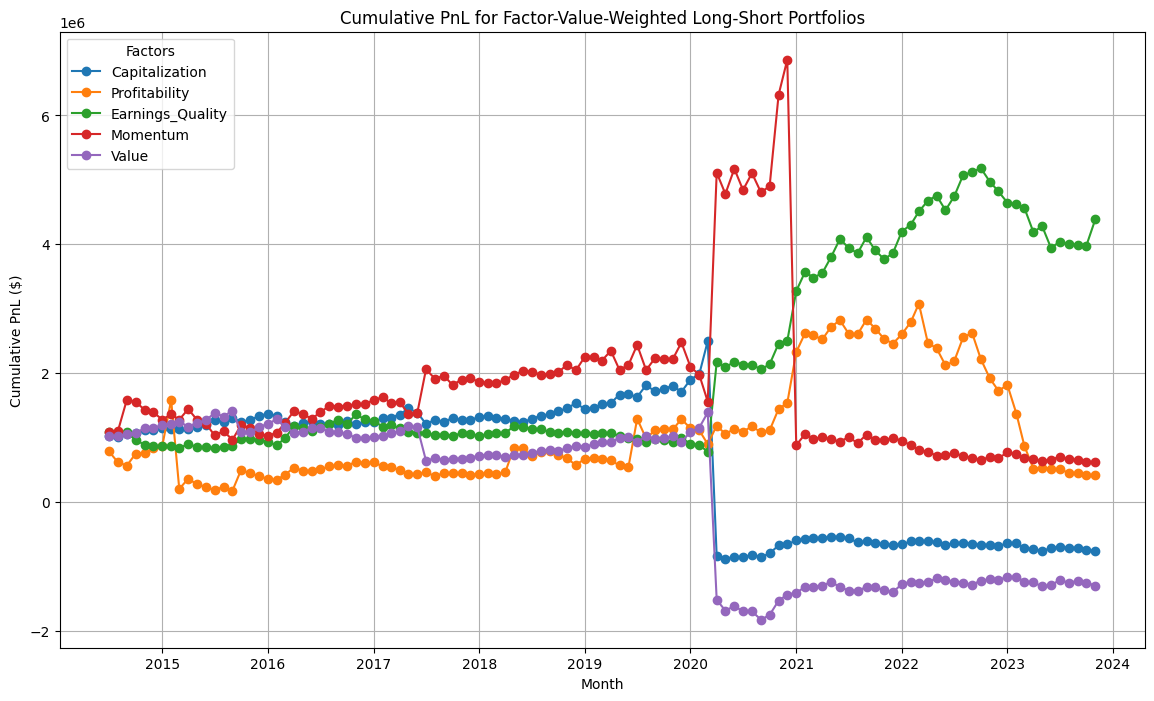

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume df has columns: PERMNO, Date, Price, Factor1, Factor2, ..., Factor6
factors = ['Capitalization', 'Profitability', 'Earnings_Quality', 'Momentum', 'Value']
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'PERMNO'])

# Calculate monthly returns
df['Monthly_Return'] = df.groupby('PERMNO')['Price'].pct_change()
df = df.dropna(subset=['Monthly_Return'])
df['YearMonth'] = df['Date'].dt.to_period('M')

# Initialize capital
initial_capital = 1_000_000
cumulative_pnl = {factor: [] for factor in factors}

# Process each factor individually
for factor in factors:
    factor_pnl = []
    capital = initial_capital  # Start with initial capital
    for month, month_df in df.groupby('YearMonth'):
        month_df = month_df.copy()  # Avoid SettingWithCopyWarning
        # Rank stocks in each month by the current factor and assign quintiles
        month_df['Quintile'] = pd.qcut(month_df[factor], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

        if factor in ['Value', 'Capitalization'] and month == pd.Period('2020-04', freq='M'):
            print(f"\nDataFrame for factor {factor} in {month}:")
            Q1 = month_df[month_df['Quintile'] == 'Q1']
            Q5 = month_df[month_df['Quintile'] == 'Q5']
            print(Q1[['Quintile', factor, 'Monthly_Return']])
            print(Q5[['Quintile', factor, 'Monthly_Return']])

        # Calculate weights for Q1 (long) and Q5 (short)
        Q1 = month_df[month_df['Quintile'] == 'Q1']
        Q1['Weight'] = Q1[factor] / Q1[factor].sum()  # Normalize factor values as weights
        Q1_return = (Q1['Weight'] * Q1['Monthly_Return']).sum()

        Q5 = month_df[month_df['Quintile'] == 'Q5']
        Q5['Weight'] = Q5[factor] / Q5[factor].sum()
        Q5_return = (Q5['Weight'] * Q5['Monthly_Return']).sum()

        # Calculate the long-short portfolio return
        long_short_return = Q1_return - Q5_return

        # Update capital based on the portfolio return
        capital *= (1 + long_short_return)  # Update capital with monthly return
        factor_pnl.append({'Month': month, 'Capital': capital})

    # Store cumulative PnL for this factor
    cumulative_pnl[factor] = pd.DataFrame(factor_pnl)

# Convert each factor's results to a DataFrame for plotting
for factor, df_factor in cumulative_pnl.items():
    df_factor['Month'] = df_factor['Month'].dt.to_timestamp()  # Convert Period to Timestamp for plotting

# Plotting
plt.figure(figsize=(14, 8))
for factor, df_factor in cumulative_pnl.items():
    plt.plot(df_factor['Month'], df_factor['Capital'], marker='o', linestyle='-', label=factor)

plt.title('Cumulative PnL for Factor-Value-Weighted Long-Short Portfolios')
plt.xlabel('Month')
plt.ylabel('Cumulative PnL ($)')
plt.legend(title='Factors')
plt.grid(True)
plt.show()

In [ ]:
# Define the period of interest
start_period = pd.Period('2020-01', freq='M')
end_period = pd.Period('2020-06', freq='M')

# Extract and print returns for the period of interest
for factor in ['Value', 'Capitalization']:
    print(f"\nMonthly Returns for {factor} Factor (Jan 2020 - Jun 2020):")
    returns_df = cumulative_pnl[factor]
    returns_df = returns_df[(returns_df['Month'] >= start_period.start_time) & (returns_df['Month'] <= end_period.end_time)]
    print(returns_df[['Month', 'Capital']])



Monthly Returns for Value Factor (Jan 2020 - Jun 2020):
        Month       Capital
72 2020-01-01  1.646355e+06
73 2020-02-01  1.751638e+06
74 2020-03-01  2.141818e+06
75 2020-04-01 -1.238247e+06
76 2020-05-01 -1.327532e+06
77 2020-06-01 -1.291686e+06

Monthly Returns for Capitalization Factor (Jan 2020 - Jun 2020):
        Month       Capital
72 2020-01-01  1.791733e+06
73 2020-02-01  1.883489e+06
74 2020-03-01  2.377982e+06
75 2020-04-01 -1.323690e+06
76 2020-05-01 -1.393723e+06
77 2020-06-01 -1.332037e+06


In [ ]:
df[df['YearMonth']== pd.Timestamp('2020-04-01').to_period('M')]

,PERMNO,Date,Price,Capitalization,Profitability,Earnings_Quality,Momentum,Value,Monthly_Return,YearMonth
76,10104,2020-04-01,52.970,-18.933776,0.539575,-0.030682,-0.084243,0.085216,0.096007,2020-04
196,10107,2020-04-01,179.210,-21.030036,0.443507,-0.035766,0.355448,0.081184,0.136326,2020-04
316,10138,2020-04-01,115.630,-17.085516,0.348007,0.071517,0.003954,0.247819,0.184127,2020-04
436,10145,2020-04-01,141.900,-18.424314,0.308802,-0.012950,-0.140685,0.160204,0.060617,2020-04
633,10516,2020-04-01,37.140,-16.845388,0.068785,0.161052,-0.154525,0.790256,0.055713,2020-04
...,...,...,...,...,...,...,...,...,...,...
48241,92602,2020-04-01,74.600,-18.570495,NaN,-0.070274,-0.124166,NaN,0.022478,2020-04
48361,92611,2020-04-01,178.720,-19.535496,0.364829,-0.013784,0.037984,0.085651,0.109235,2020-04
48536,92655,2020-04-01,292.470,-19.439866,0.255474,-0.028359,0.026238,0.217476,0.172789,2020-04
48764,93096,2020-04-01,175.300,-17.601757,0.243708,-0.029168,0.277240,0.167331,0.160850,2020-04


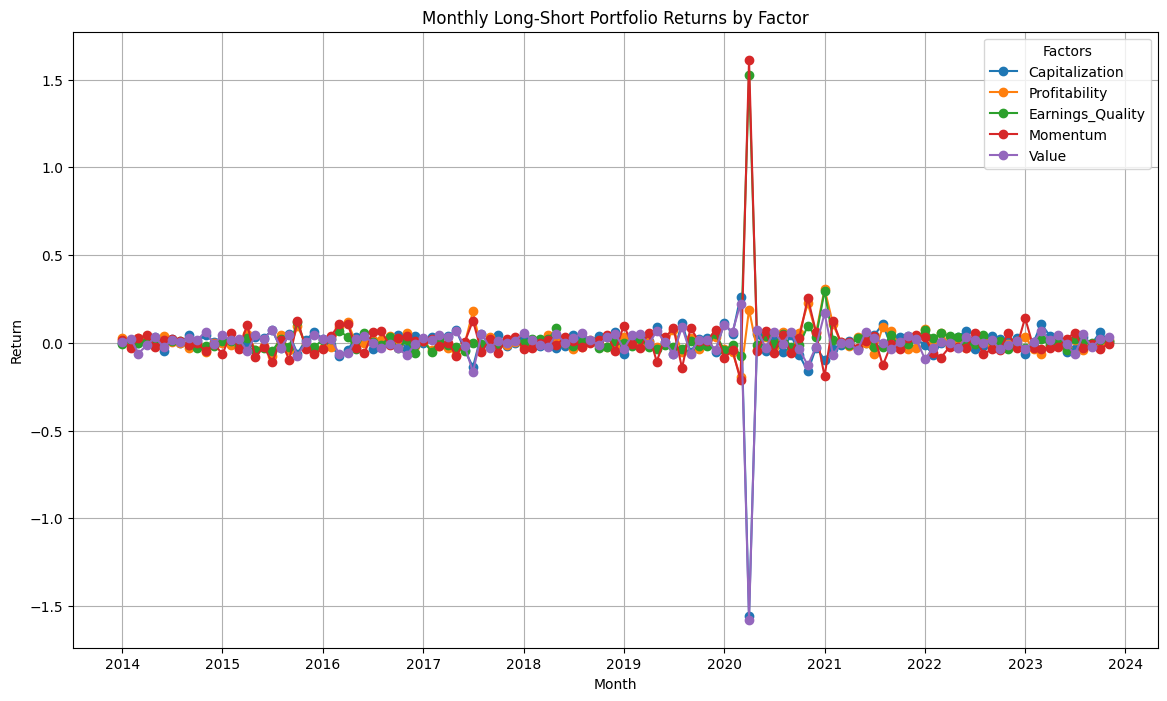

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume df has columns: PERMNO, Date, Price, Factor1, Factor2, ..., Factor6
factors = ['Capitalization', 'Profitability', 'Earnings_Quality', 'Momentum', 'Value']
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'PERMNO'])

# Calculate monthly returns
df['Monthly_Return'] = df.groupby('PERMNO')['Price'].pct_change()
df = df.dropna(subset=['Monthly_Return'])
df['YearMonth'] = df['Date'].dt.to_period('M')

# Dictionary to store long-short returns for each factor
factor_returns = {factor: [] for factor in factors}

# Process each factor individually
for factor in factors:
    for month, month_df in df.groupby('YearMonth'):
        # Rank stocks in each month by the current factor and assign quintiles
        month_df['Quintile'] = pd.qcut(month_df[factor], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

        # Calculate returns for Q1 (long) and Q5 (short)
        long_portfolio = month_df[month_df['Quintile'] == 'Q1']['Monthly_Return'].mean()
        short_portfolio = month_df[month_df['Quintile'] == 'Q5']['Monthly_Return'].mean()

        # Calculate the long-short portfolio return
        long_short_return = long_portfolio - short_portfolio

        # Append the return for this factor and month
        factor_returns[factor].append({'Month': month, 'Long_Short_Return': long_short_return})

# Convert each factor's results to a DataFrame for plotting
factor_returns_df = {}
for factor, returns in factor_returns.items():
    df_factor = pd.DataFrame(returns)
    df_factor['Month'] = df_factor['Month'].dt.to_timestamp()  # Convert Period to Timestamp for plotting
    factor_returns_df[factor] = df_factor

# Plotting
plt.figure(figsize=(14, 8))
for factor, df_factor in factor_returns_df.items():
    plt.plot(df_factor['Month'], df_factor['Long_Short_Return'], marker='o', linestyle='-', label=factor)

plt.title('Monthly Long-Short Portfolio Returns by Factor')
plt.xlabel('Month')
plt.ylabel('Return')
plt.legend(title='Factors')
plt.grid(True)
plt.show()

## More about data

In [ ]:
# Group by 'YearMonth' and count the total months in the dataset
total_months = df['YearMonth'].nunique()
# 119 months

# Group by 'YearMonth' and count the unique companies (PERMNO) available per month
companies_per_month = df.groupby('YearMonth')['PERMNO'].nunique()

# Count NaN values in each factor exposure
nan_counts = df[['Capitalization', 'Profitability', 'Earnings_Quality', 'Momentum', 'Value']].isna().sum()

# Calculate the distributions of each factor exposure (summary statistics)
factor_distributions = df[['Capitalization', 'Profitability', 'Earnings_Quality', 'Momentum', 'Value']].describe()

In [ ]:
nan_counts

,0
Capitalization,0
Profitability,2111
Earnings_Quality,687
Momentum,92
Value,2426


In [ ]:
companies_per_month

,PERMNO
YearMonth,
2014-01,474
2014-02,473
2014-03,473
2014-04,472
2014-05,470
...,...
2023-07,362
2023-08,361
2023-09,361


In [ ]:
factor_distributions

,Capitalization,Profitability,Earnings_Quality,Momentum,Value
count,48397.000000,46286.000000,47710.000000,48305.000000,45971.000000
mean,-16.910962,0.185370,-0.044718,0.130031,0.460537
std,1.319432,0.349353,0.061557,0.353215,0.439121
min,-21.845381,-6.489409,-0.809245,-0.949605,0.009851
25%,-17.711339,0.071351,-0.065341,-0.061757,0.181491
50%,-16.896187,0.138243,-0.037982,0.106576,0.342073
75%,-16.128151,0.249531,-0.014149,0.280401,0.631964
max,-9.344574,2.424879,0.399397,8.465726,7.551749


## Before calculating returns, Check if consecutive

In [ ]:
# Re-import necessary library and reload the dataset since the session was reset
import pandas as pd
# Convert 'Date' column to datetime for easier manipulation
df['Date'] = pd.to_datetime(df['Date'])

# Group by 'PERMNO' and sort by 'Date' within each group
df_sorted = df.sort_values(by=['PERMNO', 'Date'])

# Check for gaps in consecutive months for each company
df_sorted['Month_Diff'] = df_sorted.groupby('PERMNO')['Date'].diff().dt.days

# Identify companies with non-consecutive data (gaps not equal to ~30 days)
non_consecutive = df_sorted[df_sorted['Month_Diff'] > 31]['PERMNO'].unique()

# Output the unique PERMNOs with non-consecutive data
non_consecutive


array([], dtype=int64)

## Monthly Returns, lag 1

bacause we decide the portfolio for next month based on factor exposures of this month.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by PERMNO and Date
df_sorted = df.sort_values(by=['PERMNO', 'Date'])

# Calculate the monthly return for each stock
df_sorted['Monthly_Return_Calculated'] = (
    df_sorted.groupby('PERMNO')['Price']
    .pct_change()
)

# Lag the calculated return by one month for each stock
df_sorted['Lagged_Monthly_Return'] = (
    df_sorted.groupby('PERMNO')['Monthly_Return_Calculated']
    .shift(-1)
)

# Display the updated DataFrame with the new columns
df_sorted[['PERMNO', 'Date', 'Price', 'Monthly_Return_Calculated', 'Lagged_Monthly_Return']]


,PERMNO,Date,Price,Monthly_Return_Calculated,Lagged_Monthly_Return
1,10104,2014-01-01,36.90,NaN,0.059892
2,10104,2014-02-01,39.11,0.059892,0.046024
3,10104,2014-03-01,40.91,0.046024,-0.000733
4,10104,2014-04-01,40.88,-0.000733,0.027886
5,10104,2014-05-01,42.02,0.027886,-0.035459
...,...,...,...,...,...
48890,93422,2020-10-01,0.90,-0.003101,0.788889
48891,93422,2020-11-01,1.61,0.788889,0.484472
48892,93422,2020-12-01,2.39,0.484472,0.192469
48893,93422,2021-01-01,2.85,0.192469,0.207018


In [ ]:
df_sorted

,PERMNO,Date,Price,Capitalization,Profitability,Earnings_Quality,Momentum,Value,Monthly_Return,YearMonth,Monthly_Return_Calculated,Lagged_Monthly_Return
1,10104,2014-01-01,36.90,-18.927224,0.253107,-0.050198,0.156647,0.262500,-0.035546,2014-01,NaN,0.059892
2,10104,2014-02-01,39.11,-18.985390,0.253107,-0.050198,0.050139,0.247667,0.059892,2014-02,0.059892,0.046024
3,10104,2014-03-01,40.91,-19.021784,0.253107,-0.050198,0.154317,0.238815,0.046024,2014-03,0.046024,-0.000733
4,10104,2014-04-01,40.88,-19.021050,0.253661,-0.046654,0.278777,0.245267,-0.000733,2014-04,-0.000733,0.027886
5,10104,2014-05-01,42.02,-19.048555,0.253661,-0.046654,0.263997,0.238612,0.027886,2014-05,0.027886,-0.035459
...,...,...,...,...,...,...,...,...,...,...,...,...
48890,93422,2020-10-01,0.90,-12.292245,0.050035,-0.079006,-0.739829,5.506128,-0.003101,2020-10,-0.003101,0.788889
48891,93422,2020-11-01,1.61,-12.873840,0.007388,-0.136347,-0.711818,4.803545,0.788889,2020-11,0.788889,0.484472
48892,93422,2020-12-01,2.39,-13.271847,0.007388,-0.136347,-0.478207,4.308894,0.484472,2020-12,0.484472,0.192469
48893,93422,2021-01-01,2.85,-13.447872,0.007388,-0.136347,-0.437133,4.033070,0.192469,2021-01,0.192469,0.207018


## Convert into dictionary, add columns for indicating Quintiles

In [ ]:
monthly_data_dict = {}

# Define factors for quintile calculations
factors = ['Capitalization', 'Profitability', 'Earnings_Quality', 'Momentum', 'Value']

# Add a 'YearMonth' column to group data by month
df_sorted['YearMonth'] = df_sorted['Date'].dt.to_period('M')

# Group data by 'YearMonth'
grouped = df_sorted.groupby('YearMonth')

# Construct the dictionary with quintile assignments excluding NaN values
for date, group in grouped:
    # Drop NaN values for factor calculations
    group = group.dropna(subset=factors)

    # Calculate quintiles for each factor and add as new columns
    for factor in factors:
        group[f'{factor}_quintile'] = pd.qcut(
            group[factor],
            q=5,
            labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
        )

    # Store this month's cleaned and updated data into the dictionary
    monthly_data_dict[date] = group



In [ ]:
# Display the first few rows of the data for a sample month
sample_date = list(monthly_data_dict.keys())[0]
monthly_data_dict[sample_date].head()

,PERMNO,Date,Price,Capitalization,Profitability,Earnings_Quality,Momentum,Value,Monthly_Return,YearMonth,Monthly_Return_Calculated,Lagged_Monthly_Return,Capitalization_quintile,Profitability_quintile,Earnings_Quality_quintile,Momentum_quintile,Value_quintile
1,10104,2014-01-01,36.90,-18.927224,0.253107,-0.050198,0.156647,0.262500,-0.035546,2014-01,NaN,0.059892,Q1,Q5,Q2,Q2,Q2
121,10107,2014-01-01,37.84,-19.565220,0.296174,-0.044164,0.441809,0.267040,0.011494,2014-01,NaN,0.012421,Q1,Q5,Q3,Q4,Q2
241,10138,2014-01-01,78.44,-16.839323,0.246116,-0.044956,0.312486,0.220744,-0.063627,2014-01,NaN,0.034804,Q2,Q5,Q3,Q3,Q2
361,10145,2014-01-01,91.23,-18.086406,0.230740,-0.018647,0.470503,0.219010,-0.001532,2014-01,NaN,0.035186,Q1,Q4,Q4,Q4,Q2
481,10147,2014-01-01,24.24,-17.706612,0.119862,-0.096513,0.002185,0.433890,-0.036183,2014-01,NaN,0.087871,Q1,Q3,Q1,Q1,Q3


## Calculate the overlap when rebalancing monthly

a new dataframe: YearMonth, number of companies, number of stocks in the portfolio, number of overlap stocks from lost portfolio.

## Function for Annualized Return, risk, sharpe ratio, turnover ratio.
